In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import os

In [2]:
np.random.seed(0)
torch.random.manual_seed(0)
torch.cuda.manual_seed(0)

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"     # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
                                                    # https://stackoverflow.com/questions/66682127/

In [3]:
data_path = '../data/TSLA.csv'
data = pd.read_csv(data_path)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3141,2022-12-19,154.000000,155.250000,145.820007,149.869995,149.869995,139390600
3142,2022-12-20,146.050003,148.470001,137.660004,137.800003,137.800003,159563300
3143,2022-12-21,139.339996,141.259995,135.889999,137.570007,137.570007,145417400
3144,2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3.146000e+03
mean,58.786595,60.099372,57.331557,58.733885,58.733885,9.345782e+07
std,95.696775,97.892660,93.212779,95.564559,95.564559,8.165268e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,8.894667,9.047833,8.603333,8.949500,8.949500,4.226032e+07
50%,16.201000,16.469333,15.937333,16.209333,16.209333,7.589670e+07
75%,24.492333,24.889333,24.015167,24.406667,24.406667,1.172059e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [5]:
def plot_df(df, x_col, y_col, rotate=False, rotation=0, ha=''):
    ax = df.plot(x=x_col, y=y_col)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if rotate:
        plt.xticks(rotation=rotation, ha=ha)

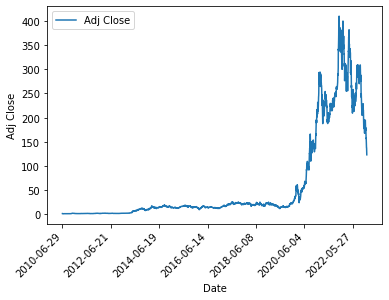

In [6]:
plot_df(data, 'Date', 'Adj Close', rotate=True, rotation=45, ha='right')

In [21]:
def get_split(df, num_X_cols, test_ratio=0.2):
    num_train_samples = int((1-test_ratio)*df.shape[0])

    X_train = df.iloc[:num_train_samples, :num_X_cols]
    Y_train = df.iloc[:num_train_samples, num_X_cols:]
    X_test = df.iloc[num_train_samples:, :num_X_cols]
    Y_test = df.iloc[num_train_samples:, num_X_cols:]
    
    # rename columns
    for i in range(X_train.shape[1]):
        X_train.columns.values[i] = i
        X_test.columns.values[i] = i
    for i in range(Y_train.shape[1]):
        Y_train.columns.values[i] = i
        Y_test.columns.values[i] = i

    return X_train, Y_train, X_test, Y_test

def scale_data(X_train, Y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # fit to training data (transform it as well)
    X_test_scaled = scaler.transform(X_test)        # transform test (acc. to train)
    Y_train_scaled = scaler.fit_transform(Y_train)
    return X_train_scaled, Y_train_scaled, X_test_scaled, scaler

# https://stackoverflow.com/questions/20410312/
# lagged data structure
num_cols = 7-1
num_X_cols = 5
lagged_data = pd.concat([data['Adj Close'].shift(i) for i in range(num_cols,0,-1)], axis=1).dropna()

test_ratio = 0.2
X_train, Y_train, X_test, Y_test = get_split(lagged_data, num_X_cols, test_ratio)
X_train, Y_train, X_test, scaler = scale_data(X_train, Y_train, X_test)
Y_test = Y_test.to_numpy()      # obviously, Y_test is not 'available' to be scaled...
                                # instead, predictions are inverse transformed

num_features = 1
X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], num_features))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], num_features))

print(f"Train: X:{X_train.shape}, Y:{Y_train.shape}\nTest: X:{X_test.shape}, Y:{Y_test.shape}")
print(type(X_train))

Train: X:(2512, 5, 1), Y:(2512, 1)
Test: X:(628, 5, 1), Y:(628, 1)
<class 'numpy.ndarray'>


In [22]:
batch_sz = 256

train_loader_kwargs = {
    'batch_size': batch_sz
}
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train),torch.Tensor(Y_train)), **train_loader_kwargs
)

test_loader_kwargs = {
    'batch_size': batch_sz
}
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test),torch.Tensor(Y_test)), **test_loader_kwargs
)

In [23]:
for inputs, labels in train_loader:
    print(inputs.shape)     # (batch size, sequence length, input dimension)
    print(labels.shape)
    break

torch.Size([256, 5, 1])
torch.Size([256, 1])


In [24]:
# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html; more links at the end
# https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook

# https://www.youtube.com/watch?v=Gl2WXLIMvKA

class StockRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, sequence_length):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
                    # bias=True, nonlinearity='tanh'
        
        self.fc = nn.Linear(in_features=hidden_size*sequence_length, out_features=output_size)
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)           # out: (batch size, sequence length, input dims)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

In [33]:
model_args = {
    'input_size': 1,
    'output_size': 1,
    'hidden_size': 512,
    'num_layers': 1,
    'sequence_length': num_X_cols
}
model = StockRNN(**model_args)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

In [34]:
def train(num_epochs):
    for epoch in range(num_epochs):
        train_loss = 0

        model.train()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            # print(outputs.shape, labels.shape)
            assert outputs.shape==labels.shape                  # useful check

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        if epoch%10==0:
            print("Epoch:", epoch, "\tLoss:", train_loss)

In [35]:
train(200)

Epoch: 0 	Loss: 0.3185610892251134
Epoch: 10 	Loss: 0.20094374526524916
Epoch: 20 	Loss: 0.14989145565778017
Epoch: 30 	Loss: 0.10452775862358976
Epoch: 40 	Loss: 0.06557654615608044
Epoch: 50 	Loss: 0.0355787732405588
Epoch: 60 	Loss: 0.016718409038730897
Epoch: 70 	Loss: 0.00801891389710363
Epoch: 80 	Loss: 0.005308207000780385
Epoch: 90 	Loss: 0.004746151857943914
Epoch: 100 	Loss: 0.004662522856278883
Epoch: 110 	Loss: 0.0046494279517901305
Epoch: 120 	Loss: 0.00464318373929018
Epoch: 130 	Loss: 0.004636939692090891
Epoch: 140 	Loss: 0.004630235144759354
Epoch: 150 	Loss: 0.004623075424888157
Epoch: 160 	Loss: 0.0046154624769769725
Epoch: 170 	Loss: 0.004607393534342918
Epoch: 180 	Loss: 0.004598856825396069
Epoch: 190 	Loss: 0.004589844971633283


In [36]:
def predict(model, loader, inverse_transform=False, scaler=None):
    preds = []
    with torch.no_grad():               # not training, so no need to calculate gradients
        for inputs, labels in loader:
            outputs = model(inputs)
            preds.append(outputs)
    preds = torch.cat(preds, axis=0).numpy()
    if inverse_transform:
        preds = scaler.inverse_transform(preds)
    return preds

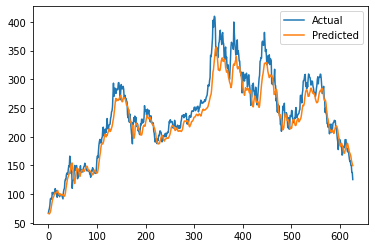

In [37]:
preds_test = predict(model, test_loader, inverse_transform=True, scaler=scaler)

actual_and_pred = pd.DataFrame(columns=['Actual','Predicted'])
actual_and_pred['Actual'] = Y_test[:,0]
actual_and_pred['Predicted'] = preds_test[:,0]
ax = actual_and_pred.plot()
plt.savefig('../results/output_size=2/xavier_512_lr=1e-5.png', bbox_inches='tight', facecolor="w")

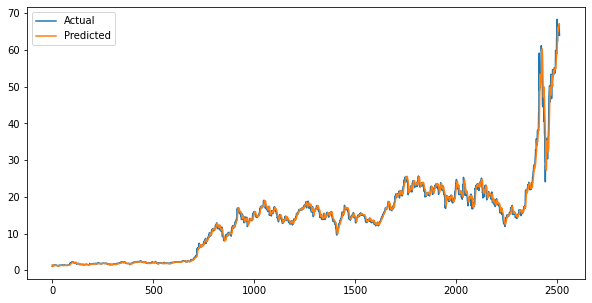

In [38]:
preds_train = predict(model, train_loader, inverse_transform=True, scaler=scaler)
train_Y_df = pd.DataFrame(columns=['Actual', 'Predicted'])
train_Y_df['Actual'] = (scaler.inverse_transform(Y_train))[:,0]
train_Y_df['Predicted'] = preds_train[:,0]
ax = train_Y_df.plot(figsize=(10,5))
plt.savefig('../results/output_size=2/train_preds_512_lr=1e-5.png', bbox_inches='tight', facecolor="w")
                                                                                    # facecolor: jupyter problem
                                                                                    # https://stackoverflow.com/questions/52371499

References:
- https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346
- https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook
- Torch:
    - RNN: https://www.youtube.com/watch?v=Gl2WXLIMvKA
    - https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
    - https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
    - https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
